# Session 3: Asymmetric GARCH Models

## Course: Advanced Volatility Modeling

---

## Learning Objectives

By the end of this session, students will be able to:
1. Understand the leverage effect and its economic interpretation
2. Derive and estimate EGARCH, GJR-GARCH, and TGARCH models
3. Compare news impact curves across models
4. Test for asymmetry in volatility response

---

## 1. The Leverage Effect

### 1.1 Empirical Evidence

Black (1976) documented that stock returns and volatility are **negatively correlated**:
- Negative returns → Increased future volatility
- Positive returns → Decreased (or unchanged) future volatility

This asymmetry is called the **leverage effect**.

### 1.2 Economic Explanations

**Leverage hypothesis** (Black, 1976; Christie, 1982):
- When stock price falls, debt-to-equity ratio rises
- Higher leverage → higher risk → higher volatility

**Volatility feedback hypothesis** (French et al., 1987; Campbell & Hentschel, 1992):
- News of higher future volatility raises required return
- Stock price must fall immediately to deliver higher expected return

### 1.3 News Impact Curve

The **News Impact Curve (NIC)** shows how today's shock affects tomorrow's variance:

$$NIC(\epsilon_{t-1}) = E[\sigma_t^2 | \epsilon_{t-1}, \sigma_{t-1}^2 = \bar{\sigma}^2]$$

For symmetric GARCH(1,1), the NIC is a **parabola centered at zero**.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
import yfinance as yf
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

np.random.seed(42)

In [3]:
# Download S&P 500 data
spy = yf.download('SPY', start='2010-01-01', end='2024-12-31', progress=False)
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.get_level_values(0)

spy['returns'] = np.log(spy['Close'] / spy['Close'].shift(1))
returns = spy['returns'].dropna() * 100  # Percentage returns

print(f"Sample: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns)}")

YF.download() has changed argument auto_adjust default to True
Sample: 2010-01-05 to 2024-12-30
Observations: 3772


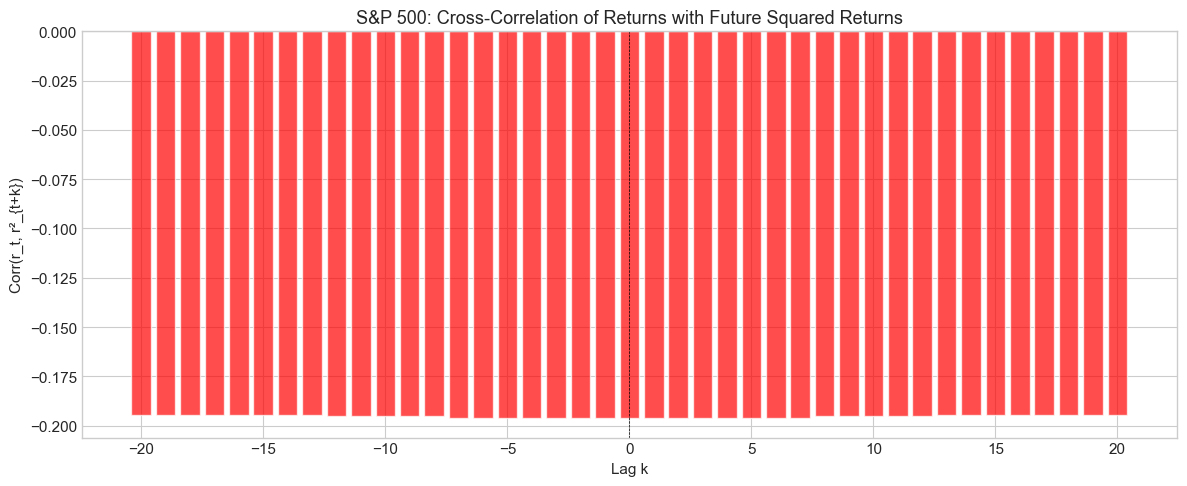


Corr(r_t, r²_{t+1}): -0.1962
Corr(r_t, r²_{t+5}): -0.1962

Negative values at positive lags confirm the leverage effect.


In [4]:
# Empirical evidence of leverage effect
def empirical_leverage_effect(returns, lags=20):
    """
    Compute cross-correlation between returns and future squared returns.
    Leverage effect implies negative correlation at positive lags.
    """
    ret = returns - returns.mean()
    sq_ret = ret ** 2
    
    correlations = []
    for lag in range(-lags, lags + 1):
        if lag < 0:
            corr = ret.iloc[-lag:].corr(sq_ret.iloc[:lag])
        elif lag > 0:
            corr = ret.iloc[:-lag].corr(sq_ret.iloc[lag:])
        else:
            corr = ret.corr(sq_ret)
        correlations.append(corr)
    
    return np.arange(-lags, lags + 1), np.array(correlations)

lags, corrs = empirical_leverage_effect(returns)

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['green' if c > 0 else 'red' for c in corrs]
ax.bar(lags, corrs, color=colors, alpha=0.7, edgecolor='white')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlabel('Lag k')
ax.set_ylabel('Corr(r_t, r²_{t+k})')
ax.set_title('S&P 500: Cross-Correlation of Returns with Future Squared Returns', fontsize=13)

plt.tight_layout()
plt.show()

print(f"\nCorr(r_t, r²_{{t+1}}): {corrs[lags==1][0]:.4f}")
print(f"Corr(r_t, r²_{{t+5}}): {corrs[lags==5][0]:.4f}")
print("\nNegative values at positive lags confirm the leverage effect.")

## 2. GJR-GARCH (Glosten-Jagannathan-Runkle)

### 2.1 Model Specification

GJR-GARCH(1,1) adds an **asymmetric term** for negative shocks:

$$\boxed{\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \gamma \epsilon_{t-1}^2 I_{t-1} + \beta \sigma_{t-1}^2}$$

where $I_{t-1} = \mathbf{1}_{\{\epsilon_{t-1} < 0\}}$ is an indicator for negative shocks.

**Interpretation**:
- Positive shock ($\epsilon_{t-1} > 0$): Impact is $\alpha$
- Negative shock ($\epsilon_{t-1} < 0$): Impact is $\alpha + \gamma$
- $\gamma > 0$ indicates leverage effect

### 2.2 Stationarity Condition

$$\alpha + \frac{\gamma}{2} + \beta < 1$$

### 2.3 News Impact Curve

$$NIC(\epsilon) = \omega + \beta\bar{\sigma}^2 + \begin{cases}
\alpha \epsilon^2 & \text{if } \epsilon \geq 0 \\
(\alpha + \gamma) \epsilon^2 & \text{if } \epsilon < 0
\end{cases}$$

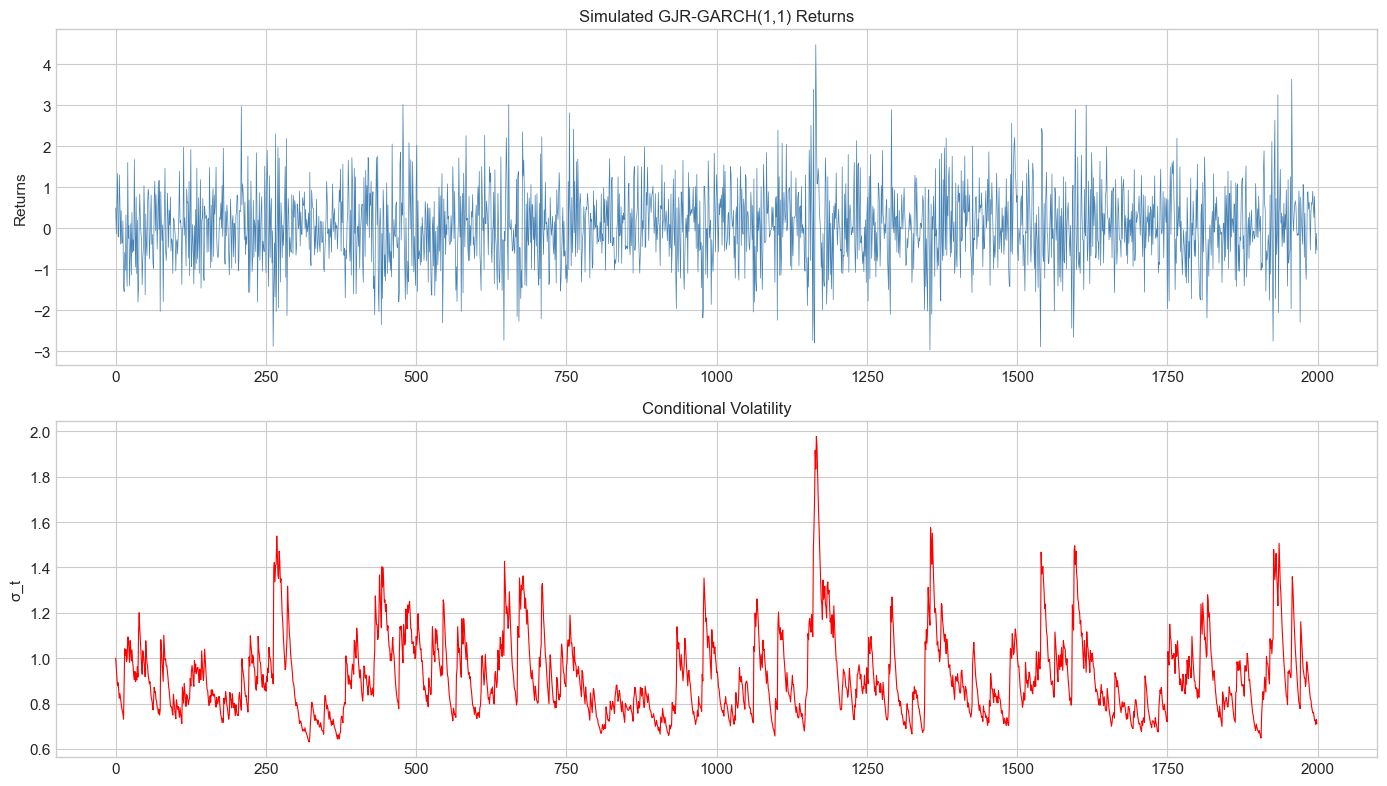

In [6]:
def simulate_gjr_garch(n, omega, alpha, gamma, beta, dist='normal', df=5):
    """
    Simulate GJR-GARCH(1,1) process.
    """
    eps = np.zeros(n)
    sigma2 = np.zeros(n)
    
    if dist == 'normal':
        z = np.random.standard_normal(n)
    else:
        z = np.random.standard_t(df, n) / np.sqrt(df / (df - 2))
    
    uncond_var = omega / (1 - alpha - gamma/2 - beta)
    sigma2[0] = uncond_var
    eps[0] = np.sqrt(sigma2[0]) * z[0]
    
    for t in range(1, n):
        indicator = 1 if eps[t-1] < 0 else 0
        sigma2[t] = omega + alpha * eps[t-1]**2 + gamma * eps[t-1]**2 * indicator + beta * sigma2[t-1]
        eps[t] = np.sqrt(sigma2[t]) * z[t]
    
    return eps, sigma2

# Simulate GJR-GARCH
n = 2000
omega, alpha, gamma, beta = 0.05, 0.05, 0.10, 0.85

np.random.seed(42)
eps_gjr, sigma2_gjr = simulate_gjr_garch(n, omega, alpha, gamma, beta)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(eps_gjr, color='steelblue', linewidth=0.5)
axes[0].set_title('Simulated GJR-GARCH(1,1) Returns', fontsize=12)
axes[0].set_ylabel('Returns')

axes[1].plot(np.sqrt(sigma2_gjr), color='red', linewidth=0.8)
axes[1].set_title('Conditional Volatility', fontsize=12)
axes[1].set_ylabel('σ_t')

plt.tight_layout()
plt.show()

In [24]:
# Fit GJR-GARCH to S&P 500
model_gjr = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='t')
fit_gjr = model_gjr.fit(disp='off')

print("GJR-GARCH(1,1) Estimation Results")
print("="*60)
print(fit_gjr.summary())

alpha_hat = fit_gjr.params['alpha[1]']
gamma_hat = fit_gjr.params['gamma[1]']

print(f"\n\nInterpretation:")
print(f"Impact of positive shock: α = {alpha_hat:.4f}")
print(f"Impact of negative shock: α + γ = {alpha_hat + gamma_hat:.4f}")
print(f"Asymmetry ratio: (α + γ)/α = {(alpha_hat + gamma_hat)/max(alpha_hat, 0.001):.2f}")

GJR-GARCH(1,1) Estimation Results
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4643.32
Distribution:      Standardized Student's t   AIC:                           9298.65
Method:                  Maximum Likelihood   BIC:                           9336.06
                                              No. Observations:                 3772
Date:                      Thu, Feb 05 2026   Df Residuals:                     3771
Time:                              09:32:08   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------

## 3. EGARCH (Exponential GARCH)

### 3.1 Model Specification

Nelson (1991) proposed EGARCH, which models **log-variance**:

$$\boxed{\ln(\sigma_t^2) = \omega + \alpha g(z_{t-1}) + \beta \ln(\sigma_{t-1}^2)}$$

where $z_t = \epsilon_t / \sigma_t$ and:

$$g(z_t) = \theta z_t + \gamma(|z_t| - E[|z_t|])$$

### 3.2 Key Properties

**Advantages over GJR-GARCH**:
1. **No parameter restrictions** for positivity (since we model log-variance)
2. **Continuous** news impact curve at zero
3. **Log-linear** structure facilitates interpretation

**Asymmetry**: $\theta < 0$ implies leverage effect

In [26]:
# Fit EGARCH to S&P 500
model_egarch = arch_model(returns, vol='EGARCH', p=1, o=1, q=1, dist='t')
fit_egarch = model_egarch.fit(disp='off')

print("EGARCH(1,1) Estimation Results")
print("="*60)
print(fit_egarch.summary())

print(f"\n\nNote: In EGARCH, alpha[1] < 0 indicates leverage effect.")
print(f"alpha[1] = {fit_egarch.params['alpha[1]']:.4f}")

EGARCH(1,1) Estimation Results
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4630.50
Distribution:      Standardized Student's t   AIC:                           9273.01
Method:                  Maximum Likelihood   BIC:                           9310.42
                                              No. Observations:                 3772
Date:                      Thu, Feb 05 2026   Df Residuals:                     3771
Time:                              09:32:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------

## 4. News Impact Curves Comparison

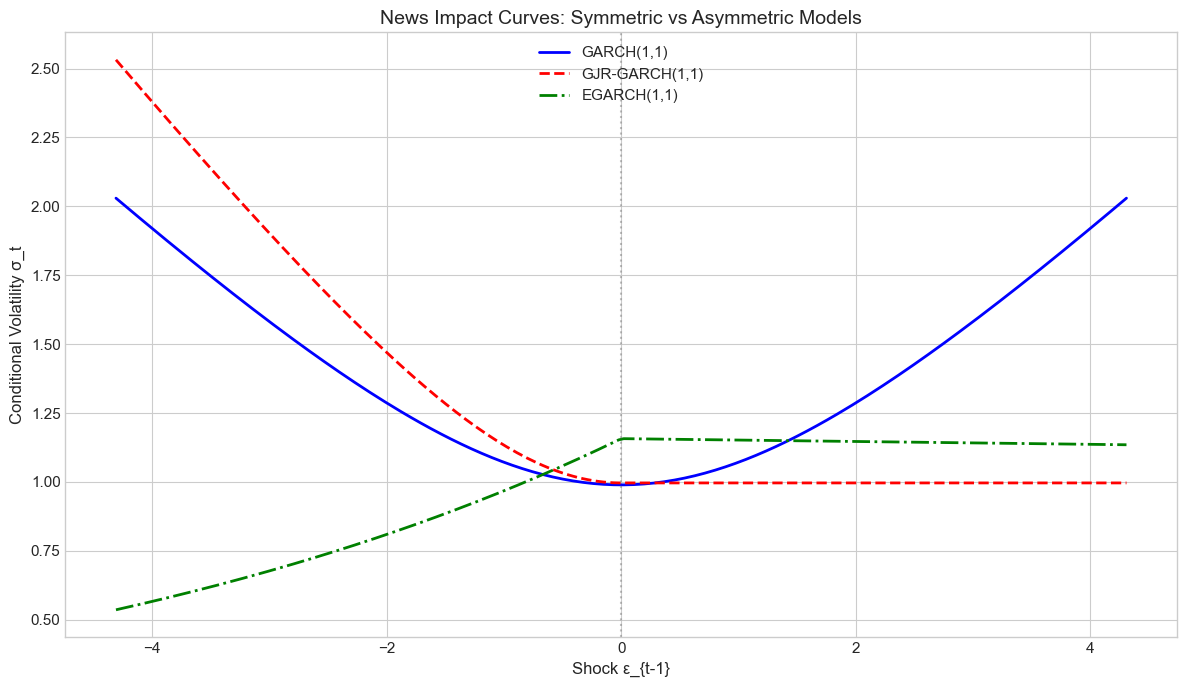


Key observations:
1. GARCH is symmetric (parabola centered at zero)
2. GJR-GARCH has a kink at zero - steeper on the left (negative shocks)
3. EGARCH is smooth and asymmetric


In [12]:
# Fit symmetric GARCH for comparison
model_garch = arch_model(returns, vol='Garch', p=1, q=1, dist='t')
fit_garch = model_garch.fit(disp='off')

def compute_news_impact_curve(fit, model_type, shock_range, uncond_var):
    """Compute news impact curve for a given model."""
    params = fit.params
    sample_std = np.sqrt(uncond_var)
    shocks = shock_range * sample_std
    
    if model_type == 'GARCH':
        omega = params['omega']
        alpha = params['alpha[1]']
        beta = params['beta[1]']
        nic = omega + beta * uncond_var + alpha * shocks**2
        
    elif model_type == 'GJR':
        omega = params['omega']
        alpha = params['alpha[1]']
        gamma = params['gamma[1]']
        beta = params['beta[1]']
        nic = omega + beta * uncond_var + alpha * shocks**2
        nic[shocks < 0] += gamma * shocks[shocks < 0]**2
        
    elif model_type == 'EGARCH':
        omega = params['omega']
        alpha = params['alpha[1]']
        gamma = params['gamma[1]']
        beta = params['beta[1]']
        z = shocks / sample_std
        log_var = omega + beta * np.log(uncond_var) + alpha * z + gamma * (np.abs(z) - np.sqrt(2/np.pi))
        nic = np.exp(log_var)
    
    return shocks, nic

# Compute NICs
shock_range = np.linspace(-4, 4, 200)
uncond_var = returns.var()

shocks_g, nic_garch = compute_news_impact_curve(fit_garch, 'GARCH', shock_range, uncond_var)
shocks_j, nic_gjr = compute_news_impact_curve(fit_gjr, 'GJR', shock_range, uncond_var)
shocks_e, nic_egarch = compute_news_impact_curve(fit_egarch, 'EGARCH', shock_range, uncond_var)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(shocks_g, np.sqrt(nic_garch), 'b-', linewidth=2, label='GARCH(1,1)')
ax.plot(shocks_j, np.sqrt(nic_gjr), 'r--', linewidth=2, label='GJR-GARCH(1,1)')
ax.plot(shocks_e, np.sqrt(nic_egarch), 'g-.', linewidth=2, label='EGARCH(1,1)')

ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Shock ε_{t-1}', fontsize=12)
ax.set_ylabel('Conditional Volatility σ_t', fontsize=12)
ax.set_title('News Impact Curves: Symmetric vs Asymmetric Models', fontsize=14)
ax.legend(loc='upper center', fontsize=11)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("1. GARCH is symmetric (parabola centered at zero)")
print("2. GJR-GARCH has a kink at zero - steeper on the left (negative shocks)")
print("3. EGARCH is smooth and asymmetric")

## 5. Testing for Asymmetry

### 5.1 Sign Bias Test (Engle & Ng, 1993)

Regress squared standardized residuals on sign indicators:

$$\hat{z}_t^2 = c_0 + c_1 S_{t-1}^- + c_2 S_{t-1}^- \hat{\epsilon}_{t-1} + c_3 S_{t-1}^+ \hat{\epsilon}_{t-1} + u_t$$

where $S_t^- = \mathbf{1}_{\{\epsilon_t < 0\}}$ and $S_t^+ = 1 - S_t^-$.

- **Sign bias test**: $H_0: c_1 = 0$
- **Negative size bias test**: $H_0: c_2 = 0$  
- **Positive size bias test**: $H_0: c_3 = 0$
- **Joint test**: $H_0: c_1 = c_2 = c_3 = 0$

In [32]:
import statsmodels.api as sm

def sign_bias_test(fitted_model):
    """
    Perform Engle-Ng sign bias tests for asymmetry.
    """
    std_resid = fitted_model.std_resid
    resid = fitted_model.resid
    
    # Create variables
    z2 = std_resid ** 2
    S_neg = (resid < 0).astype(float)
    S_pos = 1 - S_neg
    
    # Lag the indicators
    df = pd.DataFrame({
        'z2': z2,
        'S_neg_lag': S_neg.shift(1),
        'neg_size': S_neg.shift(1) * resid.shift(1),
        'pos_size': S_pos.shift(1) * resid.shift(1)
    }).dropna()
    
    # Regression
    X = sm.add_constant(df[['S_neg_lag', 'neg_size', 'pos_size']])
    y = df['z2']
    
    model = sm.OLS(y, X).fit()
    
    # Individual tests
    print("Engle-Ng Sign Bias Tests")
    print("="*60)
    print(f"\n{'Test':<25} {'Coef':>10} {'t-stat':>10} {'p-value':>10}")
    print("-"*60)
    
    tests = [
        ('Sign Bias', 'S_neg_lag'),
        ('Negative Size Bias', 'neg_size'),
        ('Positive Size Bias', 'pos_size')
    ]
    
    for test_name, var in tests:
        coef = model.params[var]
        tstat = model.tvalues[var]
        pval = model.pvalues[var]
        sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
        print(f"{test_name:<25} {coef:>10.4f} {tstat:>10.2f} {pval:>10.4f} {sig}")
    
    # Joint test (F-test)
    r_matrix = np.eye(4)[1:]  # Test all except constant
    f_test = model.f_test(r_matrix)
    print(f"\n{'Joint Test':<25} {'F-stat':>10} {'':>10} {'p-value':>10}")
    print("-"*60)
    print(f"{'H0: c1=c2=c3=0':<25} {f_test.fvalue:>10.2f} {'':<10} {f_test.pvalue:>10.4f}")
    
    return model

# Test on symmetric GARCH residuals
print("Testing GARCH(1,1) residuals for asymmetry:")
sb_garch = sign_bias_test(fit_garch)

print("\n" + "="*60)
print("\nTesting GJR-GARCH(1,1) residuals for remaining asymmetry:")
sb_gjr = sign_bias_test(fit_gjr)

Testing GARCH(1,1) residuals for asymmetry:
Engle-Ng Sign Bias Tests

Test                            Coef     t-stat    p-value
------------------------------------------------------------
Sign Bias                     0.3460       3.88     0.0001 ***
Negative Size Bias            0.0629       1.20     0.2287 
Positive Size Bias           -0.0678      -1.03     0.3045 

Joint Test                    F-stat               p-value
------------------------------------------------------------
H0: c1=c2=c3=0                  9.98                0.0000


Testing GJR-GARCH(1,1) residuals for remaining asymmetry:
Engle-Ng Sign Bias Tests

Test                            Coef     t-stat    p-value
------------------------------------------------------------
Sign Bias                     0.3186       3.13     0.0018 ***
Negative Size Bias            0.1583       2.62     0.0089 ***
Positive Size Bias           -0.0147      -0.20     0.8436 

Joint Test                    F-stat               p-v

## 6. Model Comparison

In [34]:
# Compare all models
models = {
    'GARCH(1,1)': fit_garch,
    'GJR-GARCH(1,1)': fit_gjr,
    'EGARCH(1,1)': fit_egarch
}

comparison = []
for name, fit in models.items():
    comparison.append({
        'Model': name,
        'Log-Lik': fit.loglikelihood,
        'AIC': fit.aic,
        'BIC': fit.bic,
        'Params': fit.num_params
    })

comparison_df = pd.DataFrame(comparison).set_index('Model')
print("Model Comparison")
print("="*60)
print(comparison_df.round(2))
print(f"\nBest model by BIC: {comparison_df['BIC'].idxmin()}")

Model Comparison
                Log-Lik      AIC      BIC  Params
Model                                            
GARCH(1,1)     -4711.96  9433.91  9465.09       5
GJR-GARCH(1,1) -4643.32  9298.65  9336.06       6
EGARCH(1,1)    -4630.50  9273.01  9310.42       6

Best model by BIC: EGARCH(1,1)


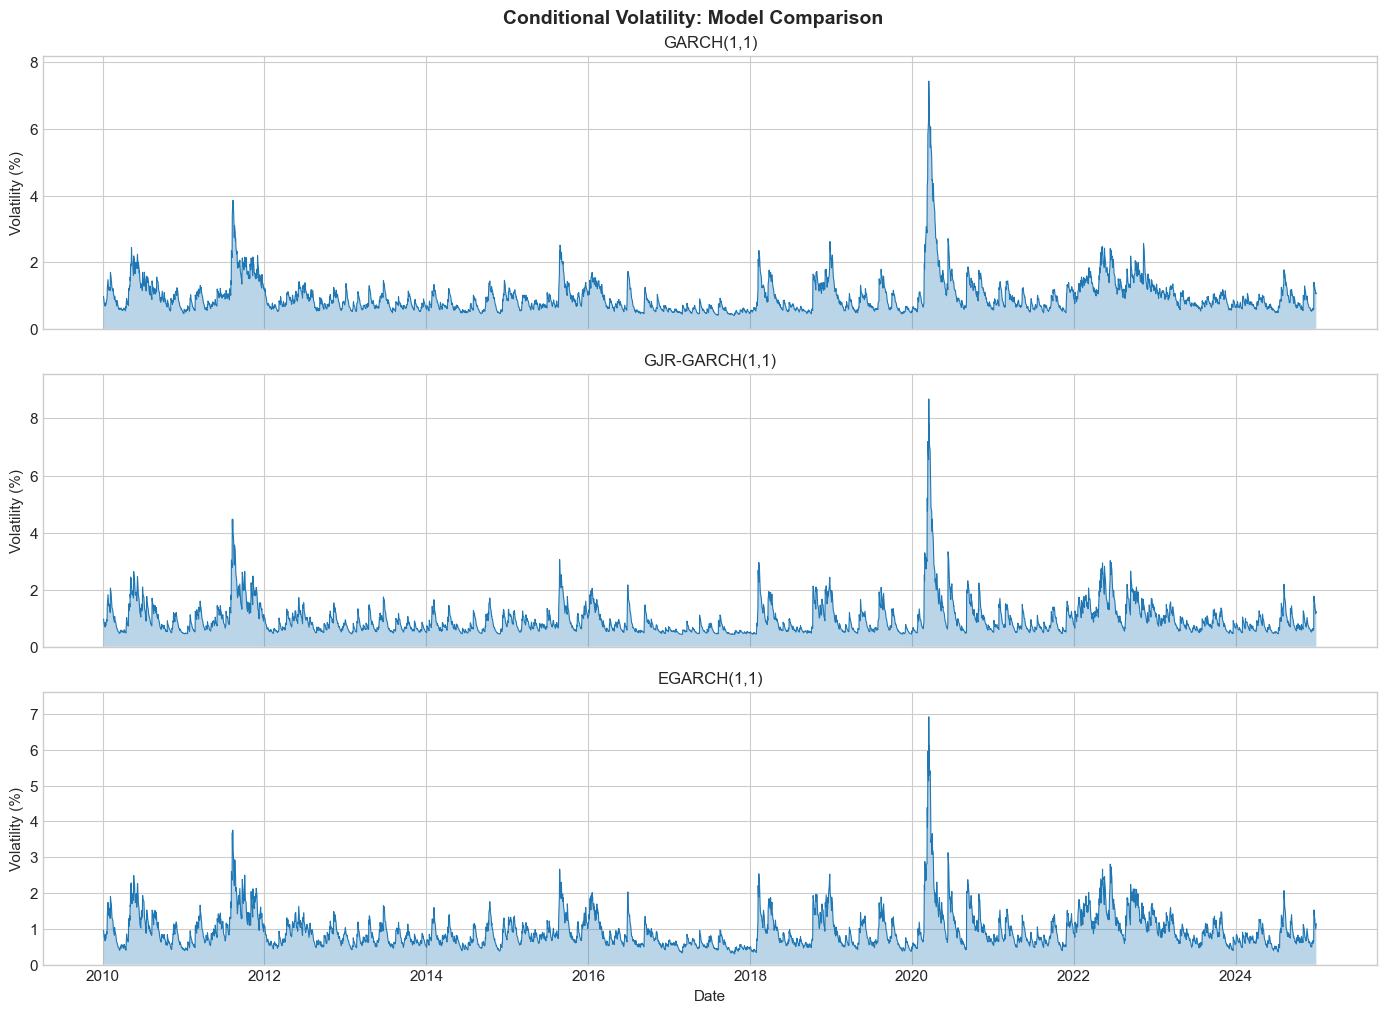

In [36]:
# Plot conditional volatility comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for ax, (name, fit) in zip(axes, models.items()):
    vol = fit.conditional_volatility
    ax.plot(vol.index, vol.values, linewidth=0.8, label=name)
    ax.fill_between(vol.index, 0, vol.values, alpha=0.3)
    ax.set_ylabel('Volatility (%)')
    ax.set_title(name, fontsize=12)
    ax.set_ylim(0, vol.max() * 1.1)

plt.xlabel('Date')
plt.tight_layout()
plt.suptitle('Conditional Volatility: Model Comparison', y=1.01, fontsize=14, fontweight='bold')
plt.show()

## 7. Cryptocurrency Application

Does the leverage effect exist in cryptocurrency markets?

In [41]:
# Download Bitcoin data
btc = yf.download('BTC-USD', start='2018-01-01', end='2024-12-31', progress=False)
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

btc_returns = (np.log(btc['Close'] / btc['Close'].shift(1)) * 100).dropna()

# Fit models
btc_garch = arch_model(btc_returns, vol='Garch', p=1, q=1, dist='t').fit(disp='off')
btc_gjr = arch_model(btc_returns, vol='Garch', p=1, o=1, q=1, dist='t').fit(disp='off')

print("Bitcoin: GARCH(1,1)")
print(btc_garch.summary())

print("\n\nBitcoin: GJR-GARCH(1,1)")
print(btc_gjr.summary())

btc_gamma = btc_gjr.params['gamma[1]']
print(f"\n\nBitcoin asymmetry parameter γ = {btc_gamma:.4f}")
if btc_gamma > 0:
    print("Bitcoin shows leverage effect (surprising for crypto!)")
else:
    print("Bitcoin shows inverse leverage effect (common in crypto)")

Bitcoin: GARCH(1,1)
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6402.25
Distribution:      Standardized Student's t   AIC:                           12814.5
Method:                  Maximum Likelihood   BIC:                           12843.7
                                              No. Observations:                 2555
Date:                      Thu, Feb 05 2026   Df Residuals:                     2554
Time:                              09:35:05   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------

## 8. Summary

### Key Takeaways

1. **Leverage effect**: Negative shocks increase volatility more than positive shocks (in equities)

2. **GJR-GARCH**: Adds asymmetric term $\gamma \epsilon_{t-1}^2 I_{t-1}$; piecewise parabolic NIC

3. **EGARCH**: Models log-variance; smooth asymmetric NIC; no positivity constraints

4. **Testing**: Engle-Ng sign bias tests detect asymmetry in GARCH residuals

5. **Crypto**: May show **inverse** leverage effect (positive returns increase volatility)

### Preview of Session 4

Session 4 covers **advanced univariate models**: FIGARCH (long memory), APARCH (power transformations), and Component GARCH (short-run vs long-run volatility).

## Exercises

### Exercise 1: Leverage Effect Across Assets
Compare the leverage effect (γ parameter) for: S&P 500, Gold, EUR/USD, and VIX. Which assets show the strongest asymmetry?

### Exercise 2: TGARCH Implementation
Implement TGARCH(1,1) from scratch and compare its NIC to GJR-GARCH.

### Exercise 3: Forecast Comparison
Compare 22-day ahead volatility forecasts from GARCH, GJR-GARCH, and EGARCH. Which model performs best during the COVID-19 crash?

### Exercise 4: Time-Varying Asymmetry
Estimate GJR-GARCH on rolling 2-year windows for S&P 500. How does the γ parameter evolve over time?

### Exercise 5: Inverse Leverage in Crypto
Test multiple cryptocurrencies (ETH, BNB, SOL) for the leverage effect. Is the inverse leverage effect consistent across crypto assets?

## References

1. Black, F. (1976). Studies of stock price volatility changes. *Proceedings of the 1976 Meetings of the American Statistical Association*, 177-181.

2. Nelson, D. B. (1991). Conditional heteroskedasticity in asset returns: A new approach. *Econometrica*, 59(2), 347-370.

3. Glosten, L. R., Jagannathan, R., & Runkle, D. E. (1993). On the relation between the expected value and the volatility of the nominal excess return on stocks. *Journal of Finance*, 48(5), 1779-1801.

4. Engle, R. F., & Ng, V. K. (1993). Measuring and testing the impact of news on volatility. *Journal of Finance*, 48(5), 1749-1778.

5. Zakoian, J. M. (1994). Threshold heteroskedastic models. *Journal of Economic Dynamics and Control*, 18(5), 931-955.